In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

from imblearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
#SMOTE does not work with sklearn pipeline, thus we have also used imblearn pipeline
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer

from sklearn import set_config
set_config(display='diagram')

# import sys
# sys.path.insert(0,'/Users/hagiwara/code/mohit-challa/GiveMeSomeCredit/notebooks/utils')
# from plots import plot_decision_regions

In [47]:
df = pd.read_csv('../../raw_data/BankChurners.csv')
df.drop(['CLIENTNUM','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],
        axis=1, inplace=True)

In [3]:
df.head(30)

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000
5,Existing Customer,44,M,2,Graduate,Married,$40K - $60K,Blue,36,3,1,2,4010.0,1247,2763.0,1.376,1088,24,0.846,0.311
6,Existing Customer,51,M,4,Unknown,Married,$120K +,Gold,46,6,1,3,34516.0,2264,32252.0,1.975,1330,31,0.722,0.066
7,Existing Customer,32,M,0,High School,Unknown,$60K - $80K,Silver,27,2,2,2,29081.0,1396,27685.0,2.204,1538,36,0.714,0.048
8,Existing Customer,37,M,3,Uneducated,Single,$60K - $80K,Blue,36,5,2,0,22352.0,2517,19835.0,3.355,1350,24,1.182,0.113
9,Existing Customer,48,M,2,Graduate,Single,$80K - $120K,Blue,36,6,3,3,11656.0,1677,9979.0,1.524,1441,32,0.882,0.144


## Exploring corelations with heatmap

<AxesSubplot:>

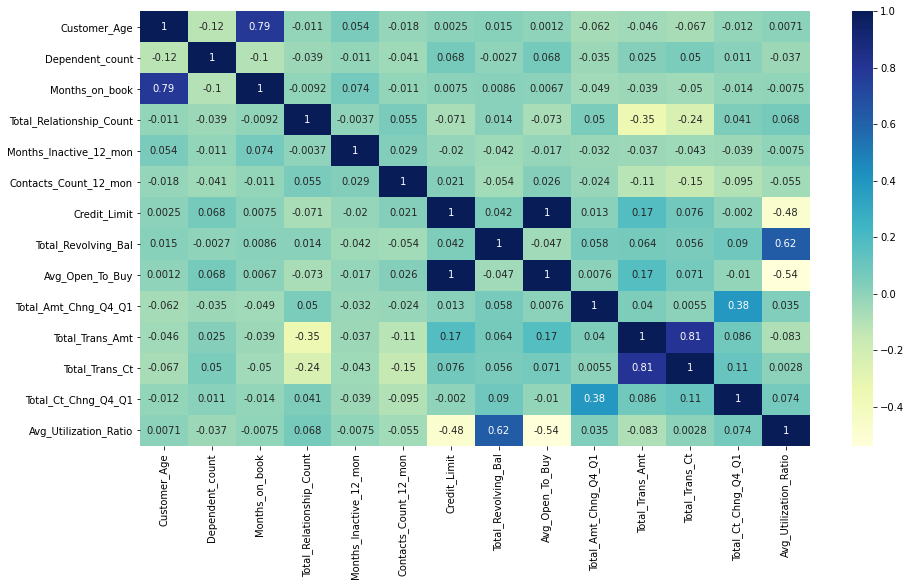

In [4]:
corr = df.corr()

fig, ax = plt.subplots(figsize=(15,8)) 

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap= "YlGnBu",
        annot=True,
        ax=ax)

In [5]:
corr_df = corr.unstack().reset_index() # Unstack correlation matrix 
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation

In [6]:
corr_df.head()

,feature_1,feature_2,correlation
118,Avg_Open_To_Buy,Credit_Limit,0.995981
92,Credit_Limit,Avg_Open_To_Buy,0.995981
151,Total_Trans_Amt,Total_Trans_Ct,0.807192
164,Total_Trans_Ct,Total_Trans_Amt,0.807192
28,Months_on_book,Customer_Age,0.788912


Dropping the `Avg_Open_To_Buy` column because of high corelation with `Credit_Limit`

In [7]:
df.drop('Avg_Open_To_Buy',axis=1, inplace=True)

## Hold-out

In [8]:
X = df.drop('Attrition_Flag', axis=1).copy()
y = df[['Attrition_Flag']].copy()
y['Existing Customer'] = LabelEncoder().fit_transform(df['Attrition_Flag'])
y.drop('Attrition_Flag', axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [9]:
X_train.head()

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
4813,47,M,2,Graduate,Divorced,$80K - $120K,Blue,40,6,1,3,16741.0,1225,0.641,3608,56,0.514,0.073
9887,54,M,1,Unknown,Single,$60K - $80K,Blue,48,4,5,4,4752.0,1230,0.883,15678,103,0.717,0.259
4191,41,F,4,Uneducated,Married,Less than $40K,Blue,33,5,2,3,2888.0,821,0.931,4713,77,1.026,0.284
7527,48,F,3,Graduate,Married,Unknown,Blue,39,3,1,2,6130.0,1741,0.578,4264,63,0.658,0.284
5081,49,M,4,College,Divorced,$120K +,Blue,41,3,1,1,7184.0,1207,0.657,3244,58,1.000,0.168


<AxesSubplot:>

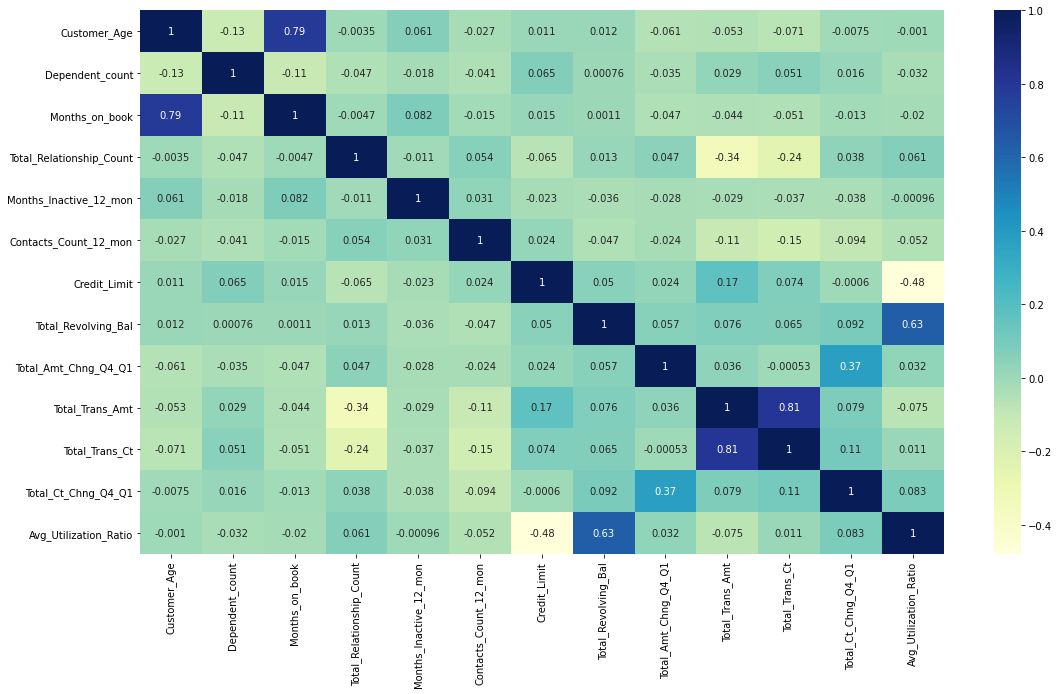

In [10]:
corr = X_train.corr()

fig, ax = plt.subplots(figsize=(18,10)) 

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap= "YlGnBu",
        annot=True,
        ax=ax)

In [11]:
corr_trained = corr.unstack().reset_index() # Unstack correlation matrix 
corr_trained.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_trained.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_trained = corr_trained[corr_trained['feature_1'] != corr_trained['feature_2']] # Remove self correlation
corr_trained.head()

,feature_1,feature_2,correlation
127,Total_Trans_Amt,Total_Trans_Ct,0.807333
139,Total_Trans_Ct,Total_Trans_Amt,0.807333
2,Customer_Age,Months_on_book,0.786712
26,Months_on_book,Customer_Age,0.786712
163,Avg_Utilization_Ratio,Total_Revolving_Bal,0.625716


## Building pipelines

In [12]:
#List of columns for encoding

categorical_columns = ['Gender', 'Marital_Status']

ordinal_columns = ['Education_Level', 'Card_Category', 'Income_Category']

numerical_columns = ['Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count',
                     'Months_Inactive_12_mon','Contacts_Count_12_mon','Credit_Limit','Total_Revolving_Bal',
                    'Total_Amt_Chng_Q4_Q1','Total_Trans_Amt','Total_Trans_Ct','Total_Ct_Chng_Q4_Q1',
                    'Avg_Utilization_Ratio']

#Column categories for ordinal encoding

card_category = ['Blue', 'Silver', 'Gold', 'Platinum']
education_category = ['Uneducated', 'High School', 'College', 'Unknown', 'Graduate', 'Post-Graduate', 'Doctorate']
income_category = ['Less than $40K', '$40K - $60K', 'Unknown','$60K - $80K', '$80K - $120K', '$120K +']

In [13]:
preprocessing = ColumnTransformer(
    [('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
     ('ord', OrdinalEncoder(categories=[education_category, card_category, income_category]), ordinal_columns),
     ('num', StandardScaler(), numerical_columns)])

smote = SMOTE(random_state=0)

log = imbPipeline([
    ('preprocess', preprocessing),
    ('smote', smote),
    ('classifier', LogisticRegression(random_state=42))])

knn = imbPipeline([
    ('preprocess', preprocessing),
    ('smote', smote),
    ('classifier', KNeighborsClassifier(n_neighbors=3, p=1))])

svm = imbPipeline([
    ('preprocess', preprocessing),
    ('smote', smote),
    ('classifier', SVC(C=100, kernel='poly', probability=True, random_state=42))])

rf = imbPipeline([
    ('preprocess', preprocessing),
    ('smote', smote),
    ('classifier', RandomForestClassifier(criterion='entropy', min_samples_split=2, n_estimators=500, random_state=42))])

In [14]:
log.fit(X_train, y_train)
knn.fit(X_train, y_train)
svm.fit(X_train, y_train)
rf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender', 'Marital_Status']),
                                                 ('ord',
                                                  OrdinalEncoder(categories=[['Uneducated',
                                                                              'High '
                                                                              'School',
                                                                              'College',
                                                                              'Unknown',
                                                                              'Graduate',
                                                                              'Post-Graduate',
                                                                              'Doctorate'],
                                                                             ['Blue',
                                                                              'Silver',
                                                                              'Gold',
                                                                              'Platinum'],
                                                                             ['Less '
                                                                              'than '
                                                                              '$40K',
                                                                              '$40K '
                                                                              '- '
                                                                              '$60K',
                                                                              'Unknown',
                                                                              '$60K '
                                                                              '-...
                                                   'Months_on_book',
                                                   'Total_Relationship_Count',
                                                   'Months_Inactive_12_mon',
                                                   'Contacts_Count_12_mon',
                                                   'Credit_Limit',
                                                   'Total_Revolving_Bal',
                                                   'Total_Amt_Chng_Q4_Q1',
                                                   'Total_Trans_Amt',
                                                   'Total_Trans_Ct',
                                                   'Total_Ct_Chng_Q4_Q1',
                                                   'Avg_Utilization_Ratio'])])),
                ('smote', SMOTE(random_state=0)),
                ('classifier',
                 RandomForestClassifier(criterion='entropy', n_estimators=500,
                                        random_state=42))])

## Logistic Regression: Cross Validation

In [15]:
log_cv_results = cross_validate(log, X_train, y_train, cv=10, 
                            scoring=['accuracy','recall','precision','f1'])

In [16]:
print('Accuracy:\n', log_cv_results['test_accuracy'].mean())
print('\nRecall\n', log_cv_results['test_recall'].mean())
print('\nPrecision\n', log_cv_results['test_precision'].mean())
print('\nf1:\n', log_cv_results['test_f1'].mean())

Accuracy:
 0.8510143992095177

Recall
 0.8539823135318059

Precision
 0.9634069647438516

f1:
 0.9053186577313166


## KNN Classifier

In [17]:
knn_cv_results = cross_validate(knn, X_train, y_train, cv=10, 
                            scoring=['accuracy','recall','precision','f1'], n_jobs = -1) 

In [18]:
print('Accuracy:\n', knn_cv_results['test_accuracy'].mean())
print('\nRecall:\n', knn_cv_results['test_recall'].mean())
print('\nPrecision:\n', knn_cv_results['test_precision'].mean())
print('\nf1:\n', knn_cv_results['test_f1'].mean())

Accuracy:
 0.8888240778370108

Recall:
 0.9095832190058077

Precision:
 0.9552885894187639

f1:
 0.931779202635922


#### Grid searching the KNN model

Cell converted to markdown after getting the `best_params`

knn_model = KNeighborsClassifier()

k_grid = {'n_neighbors' : [2,3,4,5], 'p': [1,2,3]}

knn_grid = GridSearchCV(knn_model, k_grid, n_jobs=-1,  cv = 10)

knn_grid.fit(X_train, y_train)

`best_params`: {'n_neighbors': 3, 'p': 1}

Update `knn_cv_results` with the best params.

## SVM

In [19]:
svm_cv_results = cross_validate(svm, X_train, y_train, cv=5, 
                            scoring=['accuracy','recall','precision','f1'], n_jobs = -1) 

In [20]:
print('Accuracy:\n', svm_cv_results['test_accuracy'].mean())
print('\nRecall:\n', svm_cv_results['test_recall'].mean())
print('\nPrecision:\n', svm_cv_results['test_precision'].mean())
print('\nf1:\n', svm_cv_results['test_f1'].mean())

Accuracy:
 0.9146436630358942

Recall:
 0.9428787039363963

Precision:
 0.9544506287357131

f1:
 0.9485614238708203


#### Grid searching the SVM model

Cell converted to markdown after getting the `best_params`

svm_model = SVC()

s_grid = {'kernel' : ['linear', 'poly', 'sigmoid'], 'C': [1,10,100]}

svm_grid = GridSearchCV(svm_model, s_grid, n_jobs=-1,  cv = 10)

svm_grid.fit(X_train, y_train)

`best_params`: {'C': 100, 'kernel': 'poly'}

## Random Forest

In [21]:
rf_cv_results = cross_validate(rf, X_train, y_train, cv=5, 
                            scoring=['accuracy','recall','precision','f1'], n_jobs = -1) 

In [42]:
print('Accuracy:\n', rf_cv_results['test_accuracy'].mean())
print('\nRecall:\n', rf_cv_results['test_recall'].mean())
print('\nPrecision:\n', rf_cv_results['test_precision'].mean())
print('\nf1:\n', rf_cv_results['test_f1'].mean())

Accuracy:
 0.9575339943244086

Recall:
 0.9761724372301295

Precision:
 0.9730845773826546

f1:
 0.9746061652791098


In [23]:
#### Grid searching the RF model
#Cell converted to markdown after getting the `best_params`
# rf_model = RandomForestClassifier()

# rf_grid_search = imbPipeline([
#     ('preprocess', preprocessing),
#     ('smote', smote),
#     ('classifier', RandomForestClassifier(random_state=42))])

# r_grid = {'n_estimators': [100, 200, 500, 1000], 'criterion':["gini", "entropy"], 'min_samples_split':[2,3,4,5]}
# rf_grid = GridSearchCV(rf_grid_search, r_grid, n_jobs=-1, cv = 5)
# rf_grid.fit(X_train, y_train)

#`best_params`: {'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 500}

## Inspecting AUC scores to select the best model

In [34]:
log_auc_score = roc_auc_score(y_test, log.predict_proba(X_test)[:,1], multi_class='ovr')
knn_auc_score = roc_auc_score(y_test, knn.predict_proba(X_test)[:,1], multi_class='ovr')
svm_auc_score = roc_auc_score(y_test, svm.predict_proba(X_test)[:,1], multi_class='ovr')
rf_auc_score = roc_auc_score(y_test, rf.predict_proba(X_test)[:,1], multi_class='ovr')

print('\nLogistic Regression AUC score: ',log_auc_score)
print('\nKNN Classifier AUC score: ',knn_auc_score)
print('\nSVM Classifier AUC score: ',svm_auc_score)
print('\nRandom Forest Classifier AUC score: ',rf_auc_score)


Logistic Regression AUC score:  0.9249291929009515

KNN Classifier AUC score:  0.8791304141111587

SVM Classifier AUC score:  0.9446308012578871

Random Forest Classifier AUC score:  0.9867915894071222


In [25]:
# plt.rcParams.update({
#     "lines.color": "white",
#     "patch.edgecolor": "white",
#     "text.color": "black",
#     "axes.facecolor": "white",
#     "axes.edgecolor": "lightgray",
#     "axes.labelcolor": "white",
#     "xtick.color": "white",
#     "ytick.color": "white",
#     "grid.color": "black",
#     "figure.facecolor": "black",
#     "figure.edgecolor": "black",
#     "savefig.facecolor": "black",
#     "savefig.edgecolor": "black"})

plt.style.use("dark_background")

Text(0, 0.5, 'Precision')

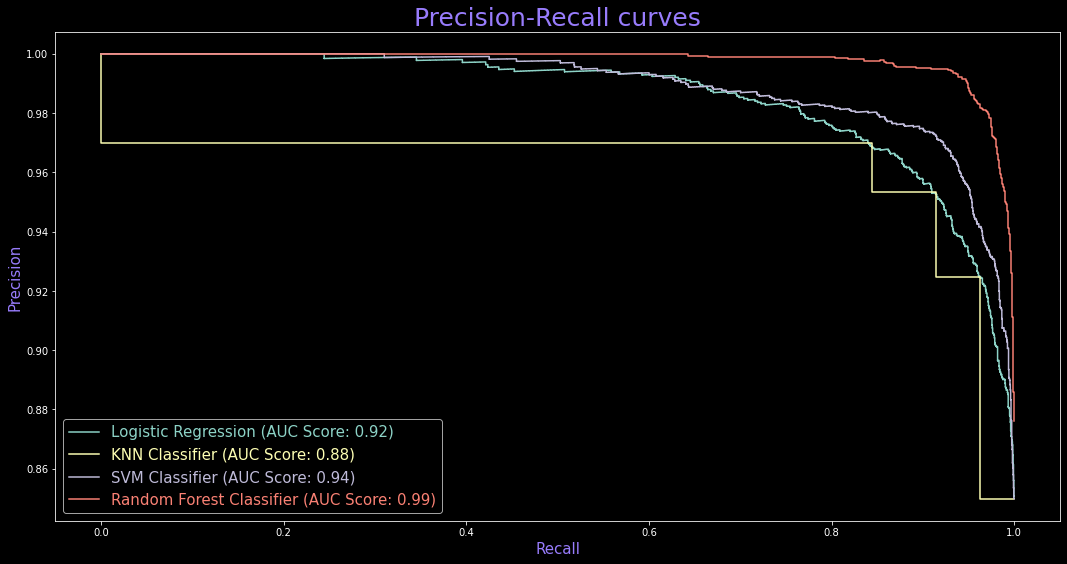

In [38]:
fig = plt.gcf()
fig.set_size_inches(18, 9)

plot_precision_recall_curve(log, X_test, y_test, ax = plt.gca(),name = 'Logistic Regression')
plot_precision_recall_curve(knn, X_test, y_test, ax = plt.gca(),name = 'KNN Classifier')
plot_precision_recall_curve(svm, X_test, y_test, ax = plt.gca(),name = 'SVM Classifier')
plot_precision_recall_curve(rf, X_test, y_test, ax = plt.gca(),name = 'Random Forest Classifier')

plt.gca().legend(('Logistic Regression (AUC Score: 0.92)','KNN Classifier (AUC Score: 0.88)','SVM Classifier (AUC Score: 0.94)','Random Forest Classifier (AUC Score: 0.99)'),
                 fontsize=15, handlelength=2, labelcolor='linecolor')

plt.title('Precision-Recall curves', fontsize=25, color="#987cfc")
plt.xlabel('Recall',fontsize=15, color="#987cfc")
plt.ylabel('Precision',fontsize=15, color="#987cfc")

# params = {"xtick.color" : "#987cfc",
#           "ytick.color" : "#987cfc"}
# plt.gca().rcParams.update(params)

### From precision-recall curves, Random Forest classifier is the best model for the given task.

## Checking Feature Importances - Making Recommendation

In [27]:
#Collecting feature importances

feat_imp = rf.named_steps["classifier"].feature_importances_

In [28]:
#Returns the names of columns from the pipeline

def get_column_names_from_ColumnTransformer(column_transformer):    
    col_name = []
    for transformer_in_columns in column_transformer.transformers_:
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1],Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names()
        except AttributeError: # if no 'get_feature_names' function, use raw column name
            names = raw_col_name
        if isinstance(names,np.ndarray): # eg.
            col_name += names.tolist()
        elif isinstance(names,list):
            col_name += names    
        elif isinstance(names,str):
            col_name.append(names)
    return col_name

In [29]:
#Collecting feature names

feat_names = get_column_names_from_ColumnTransformer(rf["preprocess"])

In [30]:
#Mapping feature importances to feature names

forest_importances = pd.Series(feat_imp, index=feat_names).sort_values(ascending=True)

In [54]:
forest_importances.index = ['Marital Status Unknown', 'Divorced', 'Card Category', 'Single', 'Married',
       'Male', 'Female', 'Education Level', 'Income Category', 'Dependent count',
       'Months on book', 'Customer Age', 'Credit Limit',
       'Contacts in a year', 'Avg Utilization Ratio',
       'Months Inactive in a year', 'Total Amount Change Q4_Q1',
       'Total Relationship Count', 'Total Count Change Q4_Q1',
       'Total Revolving Bal', 'Total Transaction Amount', 'Total Transaction Count']
forest_importances.index

Index(['Marital Status Unknown', 'Divorced', 'Card Category', 'Single',
       'Married', 'Male', 'Female', 'Education Level', 'Income Category',
       'Dependent count', 'Months on book', 'Customer Age', 'Credit Limit',
       'Contacts in a year', 'Avg Utilization Ratio',
       'Months Inactive in a year', 'Total Amount Change Q4_Q1',
       'Total Relationship Count', 'Total Count Change Q4_Q1',
       'Total Revolving Bal', 'Total Transaction Amount',
       'Total Transaction Count'],
      dtype='object')

### Printing list of available fonts

In [60]:
import matplotlib.font_manager
flist = matplotlib.font_manager.get_fontconfig_fonts()
names = [matplotlib.font_manager.FontProperties(fname=fname).get_name() for fname in flist]
print(names)

[]


findfont: Font family ['Calibri Bold'] not found. Falling back to DejaVu Sans.


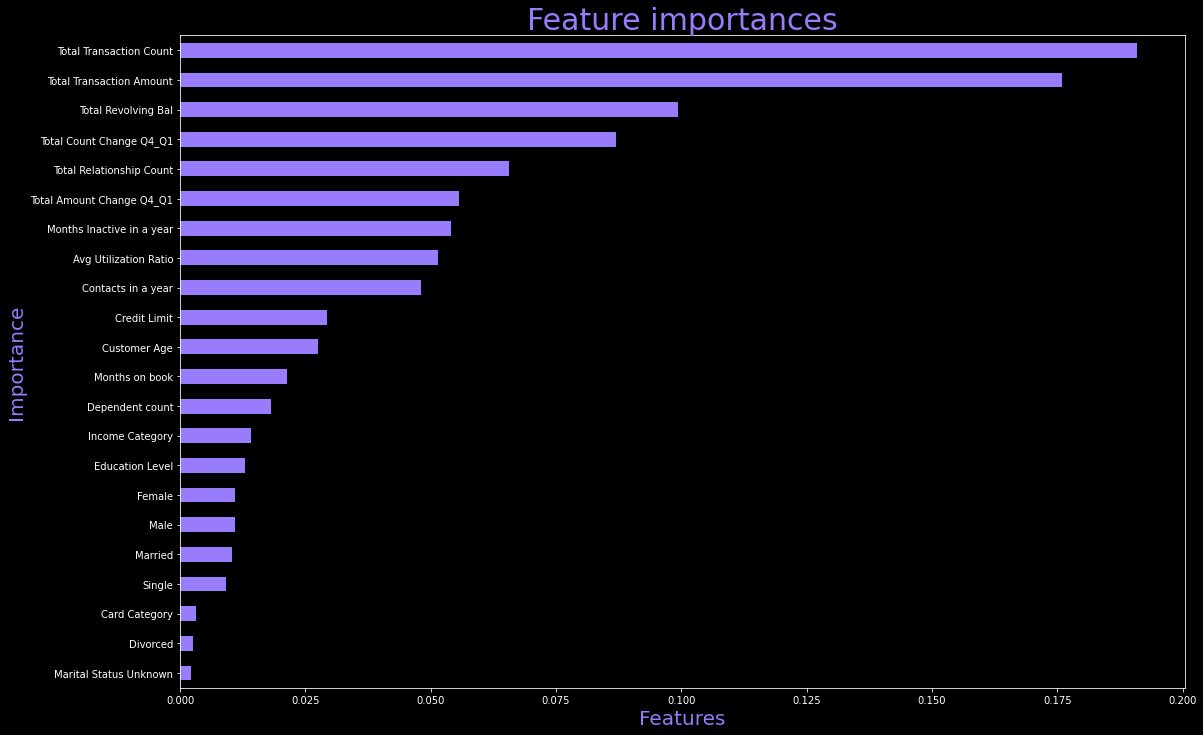

In [62]:
#Visually inspecting importance of each feature

fig = plt.gcf()
fig.set_size_inches(18, 12)

ax = forest_importances.plot.barh(color="#987cfc", )

plt.title('Feature importances', fontsize=30, color="#987cfc", fontname="Calibri Bold")
plt.xlabel('Features',fontsize=20, color="#987cfc")
plt.ylabel('Importance',fontsize=20, color="#987cfc")

features = ('Total Transaction Count', 'Total Transaction Amount', 'Total Revolving Balance', 'Total Count Change Q4_Q1',
                'Total Relationship Count', 'Total Amount Change Q4_Q1', 'Months Inactive in a Year', 'Average Utilization Ratio',
                'Contacts in a year', 'Credit Limit', 'Customer Age', 'Months on Book', 'No. of Dependents', 'Income Category', 
                'Education Level', 'Female', 'Male', 'Married', 'Single', 'Card Category', 'Divorced', 'Marital Status Unknown')

# ax = plt.axes()
# ax.set_yticklabels(features)

In [32]:
def recommendation(sample, ct_fac = 1.5, amt_fac = 1.5):
    
    """Shows comparison between original data and recommended data"""
    
    #Predicting on original data
    customer_state_before = rf.predict(sample)[0]
    customer_retention_prob_before = rf.predict_proba(sample)[0][1]*100

    #Modified data as per recommendation    
    #Increasing Total_Trans_Ct and Total_Trans_Amt by 50% as default values
    X_temp = sample
    X_temp.Total_Trans_Ct = X_temp.Total_Trans_Ct*ct_fac
    X_temp.Total_Trans_Amt = X_temp.Total_Trans_Amt*amt_fac
    
    #Predicting on modified data
    customer_state_after = rf.predict(X_temp)[0]
    customer_retention_prob_after = rf.predict_proba(X_temp)[0][1]*100
    
    return {'Original customer existing state':customer_state_before, 'Original customer existing probability (%)':customer_retention_prob_before, 'Modified customer existing state':customer_state_after, 'Modified customer existing probability (%)':customer_retention_prob_after, 'Increase in probability of customer staying (%)': customer_retention_prob_after-customer_retention_prob_before}
    

In [33]:
recommendation(X_test.iloc[[10]], ct_fac = 2, amt_fac = 3)

{'Original customer existing state': 0,
 'Original customer existing probability (%)': 49.6,
 'Modified customer existing state': 1,
 'Modified customer existing probability (%)': 84.2,
 'Increase in probability of customer staying (%)': 34.6}